Nun untersuchen wir die verschiedenen Ähnlichkeitsgraphen anhand eines anderen Datensatzes. Zunächst importieren wir alle notwendigen Bibliotheken und die relevanten Funktionen, die wir schon aus dem Notebook für Datensatz 1 kennen.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import radius_neighbors_graph
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx

In [22]:
#knn-Ähnlichkeitsgraph und Clustering
def SC_kNN_Graph (Daten, SC, k, sigma):
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    A_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance', include_self = False).toarray()  #Adjazenzmatrix mit Gewichten d_{ij}
    A_knn_con = kneighbors_graph(Daten, n_neighbors=k, mode= 'connectivity', include_self = False).toarray() #ungewichtete Adjazenzmatrix

    #Wir benutzen die Gaußsche Ähnlichkeitsfkn., um Distanzen d_{ij} in Ähnlichkeiten umzuwandeln
    #Wir müssen aufpassen, dass wenn A_2_knn_{ij} = 0, dann  S_2_knn_{ij}= 0  ebenfalls, deshalb wenden wir erst 
    #Gaußkern eintragsweise an und multiplizieren dann erneut eintragsweise mit A_2_knn_con, damit Einträge, 
    #die null waren nun wieder null sind und nicht eins.
    S_knn = A_knn_con * np.exp(- A_knn_dis ** 2 / (2. * sigma ** 2)) #Ähnlichkeitsmatrix

    #Symmetrisieren der Ähnlichkeitsmatrix 
    for i in range(n):
        for j in range(i):
            max = np.maximum(S_knn[i,j], S_knn[j,i])
            S_knn[i,j] = max
            S_knn[j,i] = max
    
    #Erstelle Graphen
    G_knn = nx.from_numpy_array(S_knn , create_using=nx.Graph)
    
    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_knn)
    
    #label
    labels = SC.labels_
    
    #Gebe Graphen und label zurück
    return(G_knn, labels)

#eps-Ähnlichkeitsgraph und Clustering
def SC_eps_Graph (Daten, SC, epsilon): 
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    ##Erstelle eps-Graphen aus Datensatz 
    
    A_eps = radius_neighbors_graph(Daten, radius= epsilon, mode= 'connectivity')
    
    S_eps = A_eps.toarray()

    #Erstelle Graph aus der Matrix
    G_eps = nx.from_numpy_array(S_eps , create_using=nx.Graph)

    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_eps)
    
    labels = SC.labels_
    
    return(G_eps, labels)


#MST-Methode zum finden von epsilon, für das der Graph zusammenhängend ist
def MST_Methode(Daten):
    A = euclidean_distances(Daten) #paarweise eukl. Distanzen

    #erstelle vollverbundenen Graphen aus Datensatz mit paarweisen Abständen als Gewichten
    G = nx.from_numpy_matrix(A)
    
    #Berechne minimalen Spannbaum mittels Kruskal Algorithmus
    min_spann_baum = nx.tree.minimum_spanning_edges(G, algorithm="kruskal", data=False)
    kantenliste = list(min_spann_baum) #Kanntenmenge des Spannbaums
    
    
    #längste Kante in minimalem Spannbaum
    max = 0
    for kante in kantenliste:
        if A[kante] >= max:
            max = A[kante]
    return(max, kantenliste, G)



#Mittelwertmethode:
def Mittelwertmethode (Daten, n):
    #Berechne kNN-Matrix mit Distanzen mit k wie oben angegeben
    k = int(np.ceil(np.log(n) +1)) #aufgerundetes k damit k integer
    
    #Adjazenzmatrix für knn-Graphen
    A_1_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance').toarray()
    
    #Mittelwert aller Einträge != 0 für jede Zeile, dies Eentspricht dem mittleren Abstand pro Knoten 
    #zu seinen k nächsten Nachbarn
    zeilen_mittelwert = np.sum(A_1_knn_dis, axis=1) /k 
    
    #mittelwert dieser Abstände
    mittelwert = np.mean(zeilen_mittelwert)
    
    return(mittelwert)


def beste_labelung (Original_label, cluster_label):
    
    #1. Varinate: Zuordnung wie vom Algorithmus zurückgegeben
    min = np.count_nonzero(Original_label - cluster_label)
    beste_label = cluster_label
    
    
    #2. Variante: 0->1, 1->2, 2->0:  
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)
        
        
    #3. Variante: 0->1, 1->0, 2->2:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=2
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #4. Variante: 0->2, 1->0, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

     #5. Variante: 0->2, 1->1, 2->0:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=1
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #6. Variante: 0->0, 1->2, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=0
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    return(min, beste_label)



Als nächstes erzeugen wir einen weiteren Beispieldatensatz, bei dem $k$-means ebenfalls Probleme hat. Dazu erzeugen wir zunächst 500 Punkte aufgeteilt in drei Blobs mit $\mu_1 = \begin{pmatrix}  -8.95 \\ -5.46 \end{pmatrix}$, 
$\mu_2 = \begin{pmatrix}  -4.59 \\ 0.09 \end{pmatrix}$ und $\mu_3 = \begin{pmatrix}  1.94 \\ 0.51 \end{pmatrix}$ und $\Sigma_1 = \Sigma_2 = \Sigma_3 = I_d$.

Also konkret: 
$Y_1, \dots ,Y_{167} \sim \mathcal{N}_2( (-8.95 \: -5.46)^\intercal, I_d)$, $Y_{168}, \dots, Y_{334} \sim \mathcal{N}_2( (-4.59 \:\: 0.09)^\intercal, I_d)$, $Y_{335}, \dots ,Y_{500} \sim \mathcal{N}_2( (1.94 \: \: 0.51)^\intercal, I_d).$
Wir tranformieren die Punkte dann durch Multiplikation mit 
\begin{align}
A = \begin{pmatrix}
        0.5 & -0.4\\
        -0.5 & 0.7
     \end{pmatrix}
\end{align} und erhalten $X_1, \dots, X_{500}$ mit $X_i = A Y_i$.

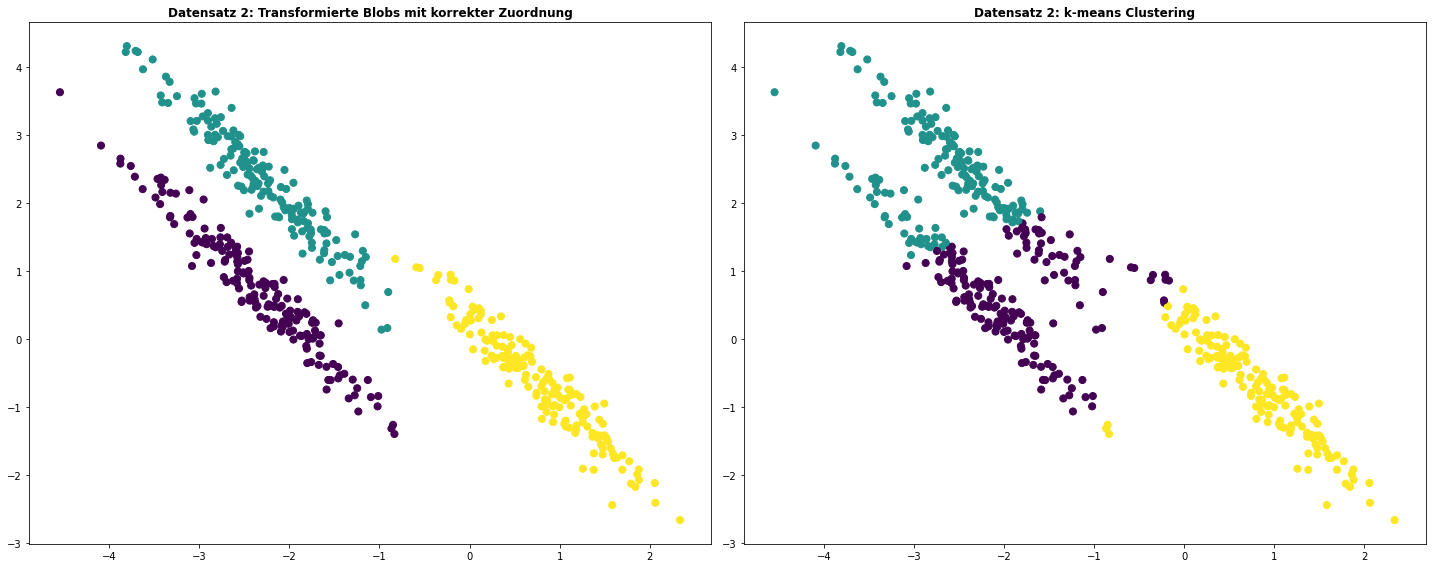

In [4]:
#Anzahl Datenpunkte
n_2 = 500
#Blobs
Daten_2, Zugehörigkeit_2 = make_blobs(n_samples=n_2,  random_state=170, 
                                              centers= [[-8.95, -5.46], [-4.59, 0.09], [ 1.94,  0.51]], 
                                              shuffle= False)

#transponierte Transformationsmatrix
transformation = [[0.5, -0.5], [-0.4, 0.7]]

#transformierte Daten
Daten_2 = np.dot(Daten_2, transformation) #entspricht Y^T * A^T, da Datenpunkte als Zeilenvektoren vorliegen



    
km = KMeans(n_clusters=3)
km.fit(Daten_2)
_ , km_labels = beste_labelung(Zugehörigkeit_2, km.labels_)



fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))

#Originalzugehörigkeit
ax[0].set_title('Datensatz 2: Transformierte Blobs mit korrekter Zuordnung', fontsize=12, fontweight='demi')
ax[0].scatter(Daten_2[:, 0],Daten_2[:, 1], s= 50, c =Zugehörigkeit_2 )

#k-means
ax[1].set_title('Datensatz 2: k-means Clustering', fontsize=12, fontweight='demi')
ax[1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= km_labels , cmap = 'viridis')

fig.tight_layout()

plt.show()





Als nächstes wollen wir  auch hier den Einfluss der Wahl des Ähnlichkeitsgraphen und der entsprechenden Parameter beim Spectralen Clustering untersuchen. Wir wandeln unsere Daten dazu wieder in verschiedene Ähnlichkeitsgraphen um.

In [5]:
#wir Erstellen Objekt der Klasse SpectralClustering, das wir für das Clustering mit kNN- und Epsilon-Graphen benutzen werden
SC_1 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels= 'kmeans')


Wir berechnen zunächst die gewichtete Ähnlichkeitsmatrix des $k$NN-Graphen für $k= \lceil \log(n) +1  \rceil = 8$ und $\sigma \approx 0.151$ aus der Mittelwertmethode und wenden Spectrales Clusetring an. Dabei gehen wir analog wie beim ersten Datensatz vor.

In [6]:
#Zunächst wenden wir SC auf knn-Graphen an mit k gegeben durch: 
k_1 =  int(np.ceil(np.log(n_2) +1))
sigma_1 = Mittelwertmethode(Daten_2, n_2)

print('k:', k_1,', sigma:', sigma_1)

G_2_knn_1, Daten_2_knn_1_labels = SC_kNN_Graph (Daten_2, SC_1, k_1, sigma = sigma_1)

k: 8 , sigma: 0.15125381557515233


Da wir für den ersten Datensatz mit $\epsilon$ aus der MST-Methode gute Ergebnisse erhalten haben, wählen wir zunächst auch hier wieder $\epsilon$ durch die MST-Methode.

In [7]:
epsilon_1, kantenmenge, G = MST_Methode(Daten_2)
print('Das kleinste Epsilon, für das wir einen verbundenen Graphen erhalten, ist: ', epsilon_1)

epsilon_1 = round(epsilon_1, 4)  #Wir runden epsilon auf 4 Nachkommastellen 

G_2_eps_1, Daten_2_eps_1_labels = SC_eps_Graph (Daten_2, SC_1, epsilon_1)


Das kleinste Epsilon, für das wir einen verbundenen Graphen erhalten, ist:  0.9061709213856154


In [9]:
#Zum Plotten der verschiedenen Graphen: Liste mit Postition in der Ebene für jeden Knoten 
pos_2= {}
for i in range (n_2):
    pos_2[i] = (Daten_2[i, 0], Daten_2[i, 1])
    

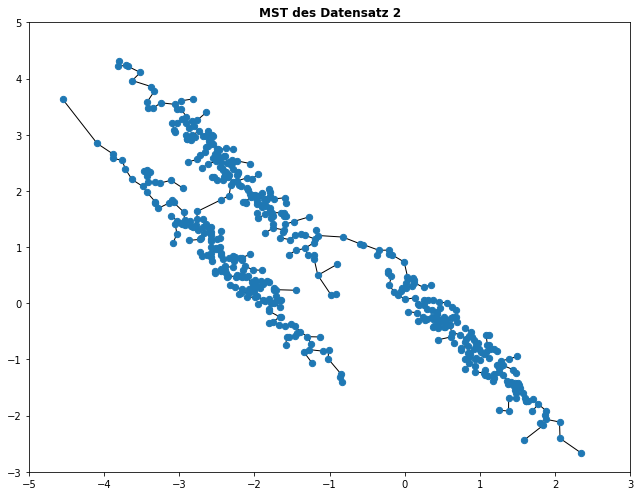

In [10]:
#Plotte Spannbaum
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('MST des Datensatz 2', fontsize=12, fontweight='demi')
nx.draw(G, pos = pos_2, edgelist =kantenmenge, node_size = 40)
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlim([-5, 3])
ax.set_ylim([-3, 5])

fig.tight_layout()
plt.show()

In [11]:
anz_falsch_knn_1, Daten_2_knn_1_labels = beste_labelung(Zugehörigkeit_2, Daten_2_knn_1_labels)
anz_falsch_eps_1, Daten_2_eps_1_labels = beste_labelung(Zugehörigkeit_2, Daten_2_eps_1_labels)

Nun plotten wir die Ergebnisse:

Beim SC mit dem kNN-Graphen mit Parameter durch die Mittelwertmethode konnten wir 499 und mit dem Epsilon-Graphen 455 von 500 Datenpunkten dem originalen Cluster zuordnen.


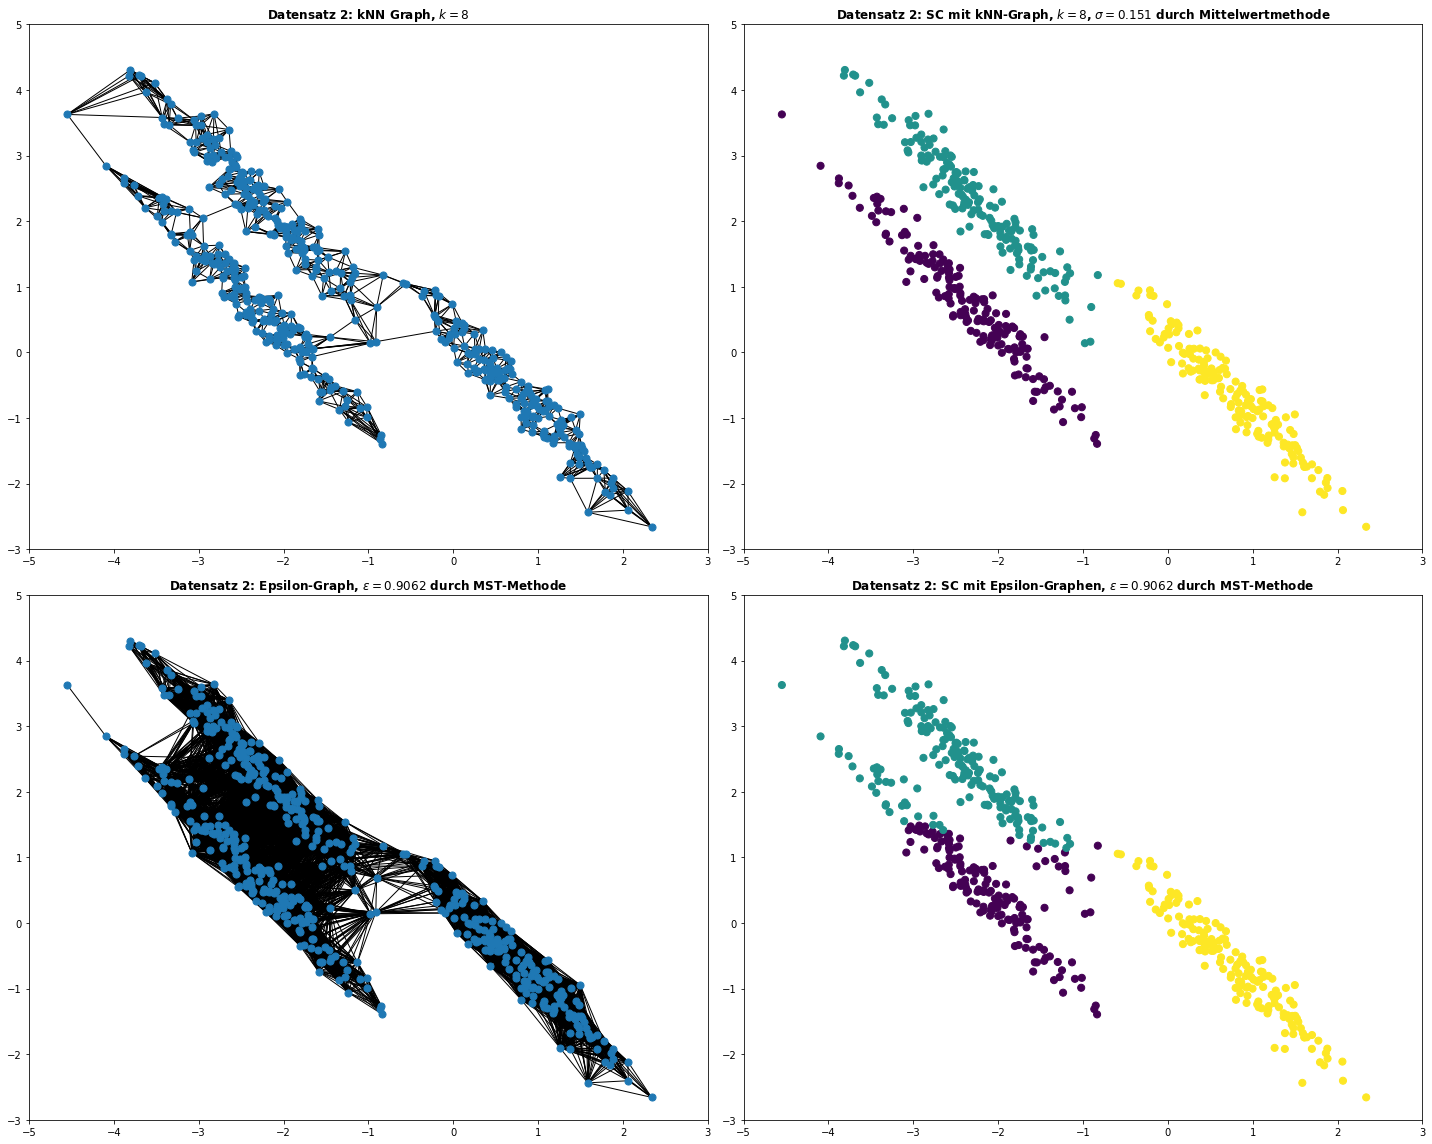

In [12]:
print('Beim SC mit dem kNN-Graphen mit Parameter durch die Mittelwertmethode konnten wir', n_2 - anz_falsch_knn_1, 
      'und mit dem Epsilon-Graphen', n_2 - anz_falsch_eps_1, 'von', n_2, 'Datenpunkten dem originalen Cluster zuordnen.')


fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,16))

ax[0,0].set_title('Datensatz 2: kNN Graph, $k = 8$', fontsize=12, fontweight='demi')
nx.draw(G_2_knn_1, pos = pos_2, node_size = 50,ax=ax[0,0] )
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,0].set_xlim([-5, 3])
ax[0,0].set_ylim([-3, 5])


ax[0,1].set_title('Datensatz 2: SC mit kNN-Graph, $k = 8$, $\sigma = 0.151$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
ax[0,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_knn_1_labels, cmap =  'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,1].set_xlim([-5, 3])
ax[0,1].set_ylim([-3, 5])

ax[1,0].set_title('Datensatz 2: Epsilon-Graph, $\epsilon =  0.9062$ durch MST-Methode', fontsize=12, fontweight='demi')
nx.draw(G_2_eps_1, pos = pos_2, node_size = 50,ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,0].set_xlim([-5, 3])
ax[1,0].set_ylim([-3, 5])

ax[1,1].set_title('Datensatz 2: SC mit Epsilon-Graphen, $\epsilon =  0.9062$ durch MST-Methode', fontsize=12, fontweight='demi')
ax[1,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_eps_1_labels, cmap =  'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,1].set_xlim([-5, 3])
ax[1,1].set_ylim([-3, 5])


fig.tight_layout()
plt.show()


Wir sehen, dass wir mit dem $k$NN-Graphen für $k = \lceil \log(n) +1  \rceil = 8$ zunächst einen zusammenhängenden Graphen erhalten, mit dem wir ein sehr gutes Clustering erhalten. Bis auf einen Punkt konnten alle Punkte richtig zugeordnet werden. 
Für den $\epsilon$-Graphen mit $\epsilon$ aus der MST-Methode ist zu beobachten, dass selbst der Ausreißerpunkt oben links mitverbunden ist. Allerdings sehen wir auch, dass dadurch die oberen beiden Blobs nun sehr stark miteinander verbunden sind. Dies führt dazu, dass das resultierende Clustering diese Punktmengen nicht komplett unterscheiden kann. 

Wir wollen nun herausfinden, wie sie das Clustering für die jeweiligen Graphen ändert, wenn wir die Parameter anpassen. Für den $\epsilon$-Graphen wollen wir nun ein kleiners $\epsilon$ wählen. Wir entscheiden uns für $\epsilon = 0.5$. 

In [17]:
##Erstelle eps-Graphen aus Datensatz 2 mit kleinerem Epsilon
epsilon_2 = 0.5

#Erstelle Graph aus der Matrix
G_2_eps_2, Daten_2_eps_2_labels = SC_eps_Graph (Daten_2, SC_1, epsilon_2)
anz_falsch_eps_2, Daten_2_eps_2_labels = beste_labelung(Zugehörigkeit_2, Daten_2_eps_2_labels)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Beim SC mit dem Epsilon-Graphen mit epsilon = 0.5 konnten wir 497 von 500 Datenpunkten dem originalen Cluster zuordnen.


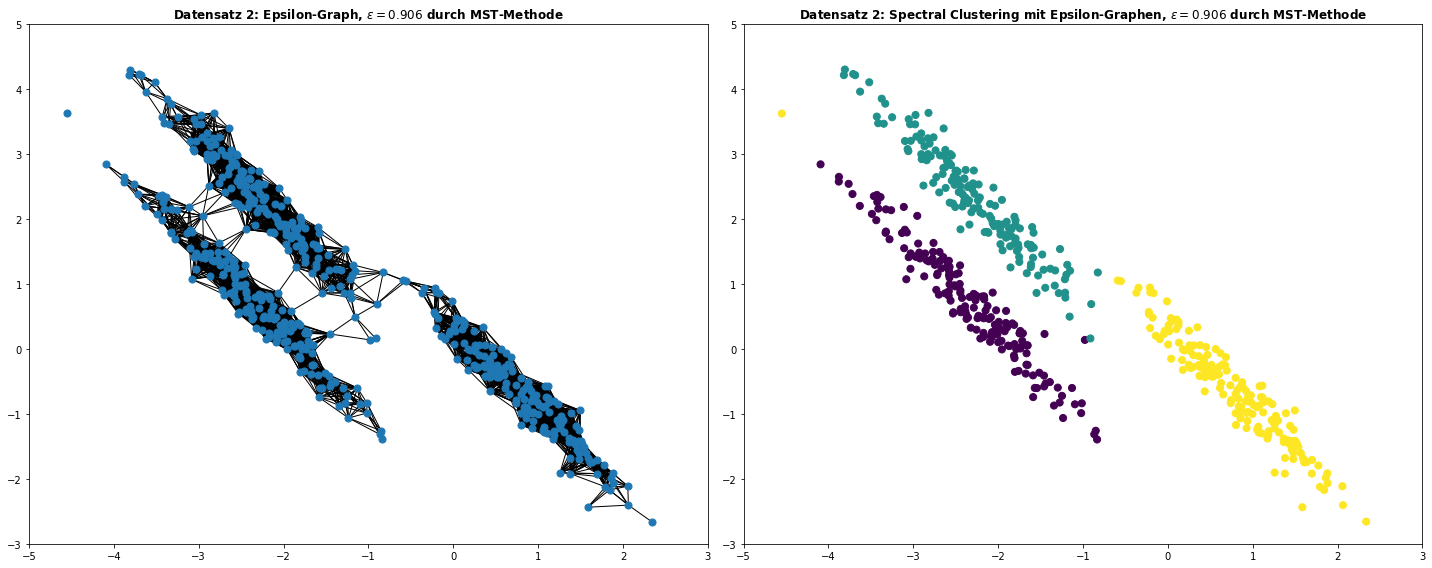

In [19]:
print('Beim SC mit dem Epsilon-Graphen mit epsilon = 0.5 konnten wir', n_2 - anz_falsch_eps_2, 'von', n_2, 
      'Datenpunkten dem originalen Cluster zuordnen.')

#plotten von Graphen und Clustering
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))


ax[0].set_title('Datensatz 2: Epsilon-Graph, $\epsilon = 0.906$ durch MST-Methode', fontsize=12, fontweight='demi')
nx.draw(G_2_eps_2, pos = pos_2, node_size = 50,ax=ax[0] )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0].set_xlim([-5, 3])
ax[0].set_ylim([-3, 5])

ax[1].set_title('Datensatz 2: Spectral Clustering mit Epsilon-Graphen, $\epsilon = 0.906$ durch MST-Methode',
                fontsize=12, fontweight='demi')
ax[1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_eps_2_labels, cmap =  'viridis')
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1].set_xlim([-5, 3])
ax[1].set_ylim([-3, 5])

fig.tight_layout()

plt.show()




Für den $\epsilon$-Graphen mit $\epsilon = 0.5$ sehen wir, dass das Graph nicht zusammenhängend ist. Der Außenseiterknoten oben links ist nicht verbunden. Da die restlichen Knoten des Graphen ansonsten zusammenhängend sind, ist das resultierende Clustering dennoch gut. Lediglich der nicht verbundene Knoten und zwei andere Knoten werden falsch zugeordnet.

 Von Luxburg empfiehlt zwar den $\epsilon$-Graphen ungewichtet zu
betrachten, wir erstellen an dieser Stelle aber dennoch eine Funktion,
mit der man eine gewichtete Version des $\epsilon$-Graphen erhält. Die
Gewichtung erfolgt ebenfalls mit der Gaußschen Ähnlichkeitsfunktion mit
Parameter $\sigma$. Diese Funktion angewandt auf $\epsilon$ aus der
MST-Methode und $\sigma$ durch die Mittelwertmethode führt für
unseren Beispieldatensatz 2 aufgrund der Gewichtung zu sehr guten
Clusterergebnissen. Deshalb empfehlen wir, falls man den
$\epsilon$-Graphen benutzen möchte, eine gewichtete Version dieses
Graphen in Betracht zu ziehen.

Anzahl richtig geordneter Punkte: 460


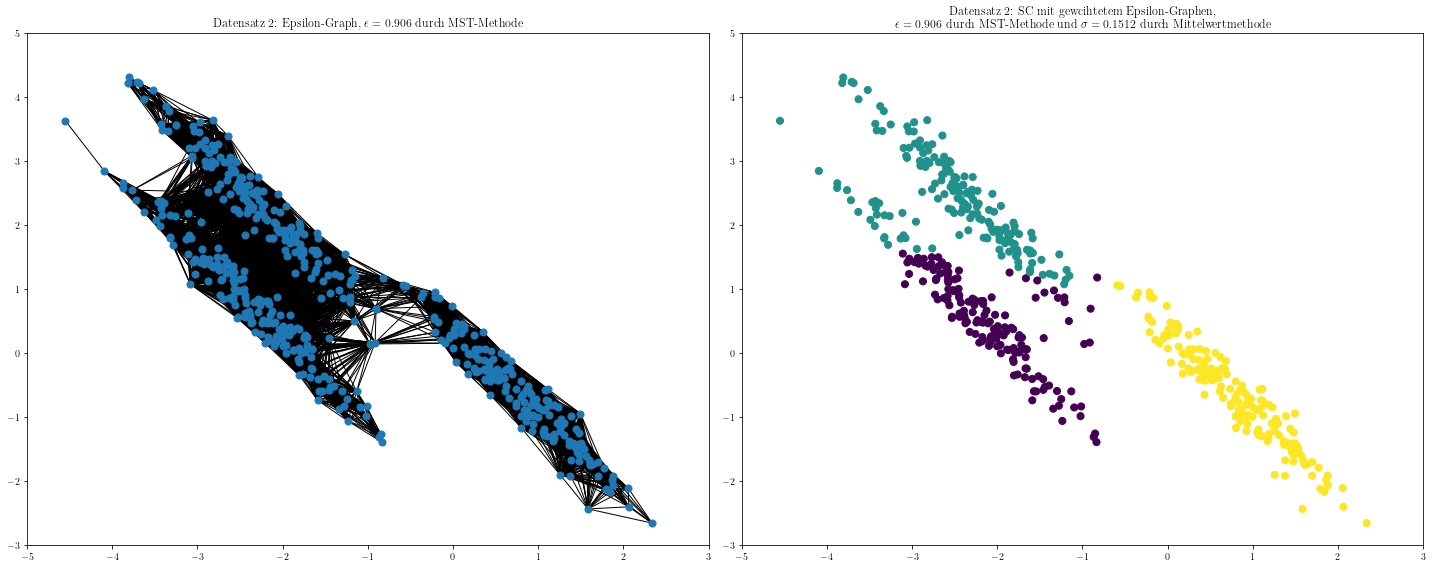

In [31]:
#eps-Ähnlichkeitsgraph gewichtet
def SC_eps_Graph_gew (Daten, SC, epsilon, sigma):
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    A_knn_dis = radius_neighbors_graph(Daten, radius= epsilon,  mode= 'distance').toarray()  #Adjazenzmatrix mit Gewichten d_{ij}
    A_knn_con = radius_neighbors_graph(Daten, radius= epsilon,  mode= 'connectivity').toarray() #ungewichtete Adjazenzmatrix

    #Wir benutzen die Gaußsche Ähnlichkeitsfkn., um Distanzen d_{ij} in Ähnlichkeiten umzuwandeln
    #Wir müssen aufpassen, dass wenn A_2_knn_{ij} = 0, dann  S_2_knn_{ij}= 0  ebenfalls, deshalb wenden wir erst 
    #Gaußkern eintragsweise an und multiplizieren dann erneut eintragsweise mit A_2_knn_con, damit Einträge, die null waren 
    #nun wieder null sind und nicht eins.
    S_knn = A_knn_con * np.exp(- A_knn_dis ** 2 / (2. * sigma ** 2)) #Ähnlichkeitsmatrix

    #Symmetrisieren der Ähnlichkeitsmatrix 
    for i in range(n):
        for j in range(i):
            max = np.maximum(S_knn[i,j], S_knn[j,i])
            S_knn[i,j] = max
            S_knn[j,i] = max
    
    #Erstelle Graphen
    G_knn = nx.from_numpy_array(S_knn , create_using=nx.Graph)
    
    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_knn)
    
    #label
    labels = SC.labels_
    
    #Gebe Graphen und label zurücl
    return(G_knn, labels)

G_2_eps_2, Daten_2_eps_2_labels = SC_eps_Graph_gew (Daten_2, SC_1, epsilon_1, sigma = sigma_1)

anz_falsch_eps_2, Daten_2_eps_2_labels = beste_labelung(Zugehörigkeit_2, Daten_2_eps_2_labels)

print('Anzahl richtig geordneter Punkte:', n_2-anz_falsch_eps_2)

#plotten von Graphen und Clustering
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))


ax[0].set_title('Datensatz 2: Epsilon-Graph, $\epsilon = 0.906$ durch MST-Methode', fontsize=12, fontweight='demi')
nx.draw(G_2_eps_2, pos = pos_2, node_size = 50,ax=ax[0] )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0].set_xlim([-5, 3])
ax[0].set_ylim([-3, 5])

ax[1].set_title('Datensatz 2: SC mit gewcihtetem Epsilon-Graphen, \n $\epsilon = 0.906$ durch MST-Methode und $\sigma = 0.1512$ durch Mittelwertmethode',
                fontsize=12, fontweight='demi')
ax[1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_eps_2_labels, cmap =  'viridis')
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1].set_xlim([-5, 3])
ax[1].set_ylim([-3, 5])

fig.tight_layout()

plt.show()


Nun überprüfen wir, ob wir $k$ für den $k$NN-Graphen noch kleiner wählen können, ohne dass der Graph in mehrere Zusammenhangskomponenten zerfällt. Dies hat den Vorteil, dass die resultierende Ähnlichkeitsmatrix dünner besetzt ist. Dazu probieren wir verschiedene Werte für $k$ aus. Wir starten mit $k= 4$ und werden sehen, dass dies auch der kleinste Wert ist, den wir wählen können. Für $k= 3$, zerfällt der Graph. Den Wert für $\sigma$ erhöhen wir im Vergleich zum $k$NN Graphen von oben auf 0.2, da wir weniger Knoten miteinander verbinden und diese somit weniger weit voneinander entfernt sind.

In [24]:
##Wir berechnen zunächst die die gewichtete Adjazenzmatrix des kNN-Graphen
k_2 =  4
k_3 = 3
G_2_knn_2, Daten_2_knn_2_labels = SC_kNN_Graph (Daten_2, SC_1, k_2, sigma = 0.2)
_, Daten_2_knn_2_labels = beste_labelung(Zugehörigkeit_2, Daten_2_knn_2_labels)

G_2_knn_3, Daten_2_knn_3_labels = SC_kNN_Graph (Daten_2, SC_1, k_3, sigma = 0.2)
_, Daten_2_knn_2_labels = beste_labelung(Zugehörigkeit_2, Daten_2_knn_2_labels)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


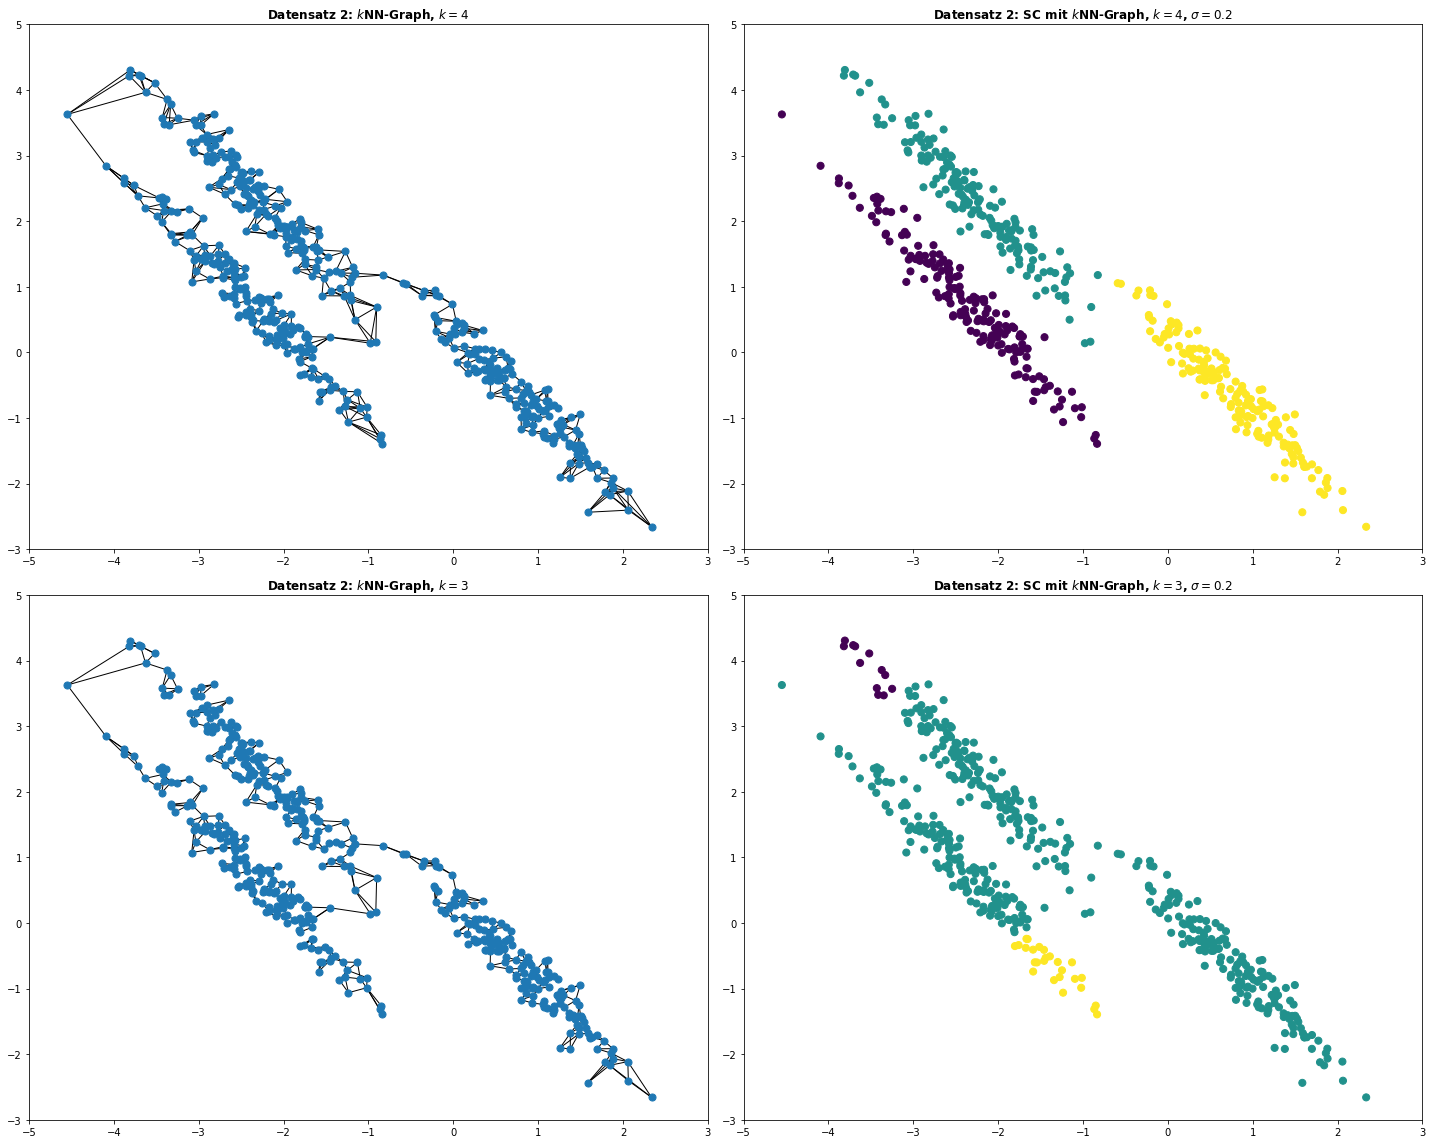

In [25]:
#Plotten beide Graphen und Clustering

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,16))


ax[0,0].set_title('Datensatz 2: $k$NN-Graph, $k = 4$ ', fontsize=12, fontweight='demi')
nx.draw(G_2_knn_2, pos = pos_2, node_size = 50,ax=ax[0,0] )
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,0].set_xlim([-5, 3])
ax[0,0].set_ylim([-3, 5])

ax[0,1].set_title('Datensatz 2: SC mit $k$NN-Graph, $k = 4$, $\sigma = 0.2$', fontsize=12, fontweight='demi')
ax[0,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_knn_2_labels, cmap =  'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,1].set_xlim([-5, 3])
ax[0,1].set_ylim([-3, 5])

ax[1,0].set_title('Datensatz 2: $k$NN-Graph, $k = 3$ ', fontsize=12, fontweight='demi')
nx.draw(G_2_knn_3, pos = pos_2, node_size = 50,ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,0].set_xlim([-5, 3])
ax[1,0].set_ylim([-3, 5])

ax[1,1].set_title('Datensatz 2: SC mit $k$NN-Graph, $k = 3$, $\sigma = 0.2$', fontsize=12, fontweight='demi')
ax[1,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_knn_3_labels, cmap =  'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,1].set_xlim([-5, 3])
ax[1,1].set_ylim([-3, 5])
fig.tight_layout()

plt.show()


Für $k = 4$ erhalten wir sowohl noch einen zusammenhängenden Graphen als auch ein gutes Clustering. Für $k=3$ dagegen sieht das anders aus. Der Graph ist nun nicht mehr zusammenhängend. Ein teil des unteren linken Blobs ist abgespalten vom Rest und wird durch den Algorithmus auch als eigenes Cluster identifiziert. ZUsätzlich ist der obererste Blob nur über Umwegen miteinander verbunden. Das Spectrale Clustrering liefert hier mangelhafte Ergebnisse. Wir müssen also $k > 3$ für diesen Datensatz wählen.

Als nächstes betrachten wir als Ähnlichkeitsgraphen den voll-verbundenen Graphen, bei dem wir alle Knoten durch Kanten miteinander verbinden und diese durch Ähnlichkeitswerte $s_{ij}$ gewichten. Die Gewichte erhalten wir wieder durch die Gaußsche Ähnlichkeitsfunktion, also 

\begin{align*}
s_{ij} = \exp\left(\frac{- \, d_{ij}\, ^2}{2\sigma^2} \right)   = \exp\left(\frac{- \| x_i - x_j\| ^2}{2\sigma^2} \right).
\end{align*} 



Ein erster Ansatz ist es $\sigma$ wie beim ersten Datensatz durch $\sigma = \epsilon$ für das $\epsilon$ aus der MST-Methode zu wählen. Dies funktioniert hier leider nicht, da wir $\sigma \leq \sqrt{\frac{1}{2}}$ wählen müssen und $\epsilon = 0.906$. Deshalb wählen wir für $\sigma$ zunächst den größmöglichen Wert, den die Implementierung von Sklearn zulässt, nämlich 
 $\sigma = \sqrt{\frac{1}{2}}  \approx 0.707 $  . 

Mit dem voll-verb.- Graphen und sigma = epsilon konnten wir  423 von 500 Datenpunkten den originalen Clustern zuordnen.


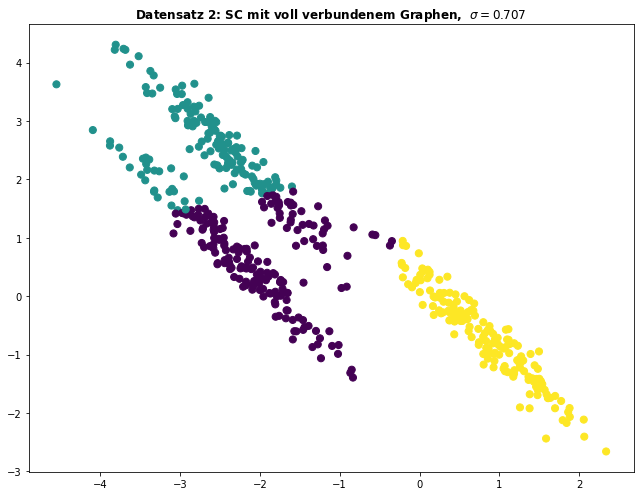

In [26]:
sigma_1 = 1/(np.sqrt(2))

gamma_1 = 1/ (2* (sigma_1)**2)



SC_2 = SpectralClustering(n_clusters=3,  gamma=gamma_1, affinity='rbf',  assign_labels='kmeans')
SC_2.fit(Daten_2)
Daten_2_voll_1_labels = SC_2.labels_
anz_falsch_voll_1, Daten_2_voll_1_labels = beste_labelung(Zugehörigkeit_2, Daten_2_voll_1_labels)

print('Mit dem voll-verb.- Graphen und sigma = epsilon konnten wir ', n_2-anz_falsch_voll_1, 'von', n_2,
      'Datenpunkten den originalen Clustern zuordnen.')

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Datensatz 2: SC mit voll verbundenem Graphen,  $\sigma = 0.707 $', fontsize=12, fontweight='demi')
ax.scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_voll_1_labels ,cmap =  'viridis')

fig.tight_layout()

plt.show()


Wie wir sehen, müssen wir $\sigma$ kleiner wählen. Der Algorithmus kann die beiden oberen Blobs nicht auseinander halten. Das Clustering ist ähnlich schlecht , wie durch $k$-means. Wir verwenden deshalb wie beim ersten Datensatz wieder die Mittelwertmethode.

Sigma durch die Mittelwertmethode: 0.15125381557515233
Mit dem voll-verb.- Graphen und sigma durch die Mittelwertmethode konnten wir  499 von 500 Datenpunkten den originalen Clustern zuordnen.


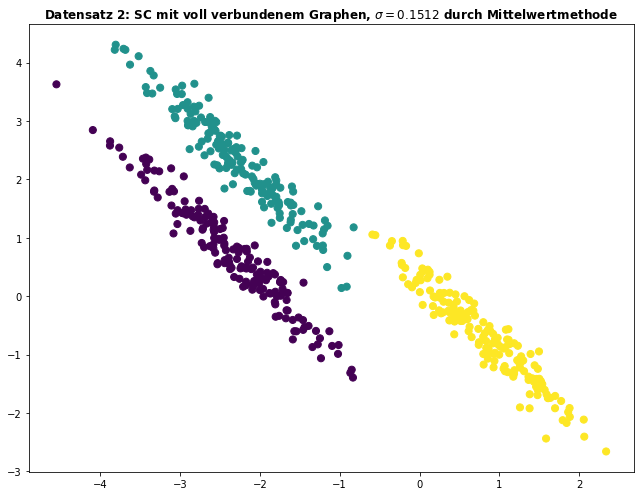

In [28]:
sigma_2 = Mittelwertmethode(Daten_2, n_2)

print('Sigma durch die Mittelwertmethode:', sigma_2) #= 0.1512


gamma_2 = 1/ (2* (sigma_2)**2)



SC_2 = SpectralClustering(n_clusters=3,  gamma=gamma_2, affinity='rbf',  assign_labels='kmeans')
SC_2.fit(Daten_2)

Daten_2_voll_2_labels= SC_2.labels_
anz_falsch_voll_2, Daten_2_voll_2_labels = beste_labelung(Zugehörigkeit_2, Daten_2_voll_2_labels)

print('Mit dem voll-verb.- Graphen und sigma durch die Mittelwertmethode konnten wir ', n_2-anz_falsch_voll_2, 'von', n_2,
      'Datenpunkten den originalen Clustern zuordnen.')

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Datensatz 2: SC mit voll verbundenem Graphen, $\sigma = 0.1512$ durch Mittelwertmethode', fontsize=12, fontweight='demi')
ax.scatter(Daten_2[:, 0], Daten_2[:, 1], s= 50, c= Daten_2_voll_2_labels, cmap = 'viridis'  )

fig.tight_layout()

plt.show()


Wir sehen, dass wir auch hier wie beim ersten Datensatz ein sehr gutes Ergebnis erhalten.

Nun fassen wir unser Ergebnisse wieder in wenigen Plots zusammen, um diese in der Arbeit zu benutzen. Die hier erzeugten Grafiken entsprechen Abbildung 6 und 7 in der Arbeit.

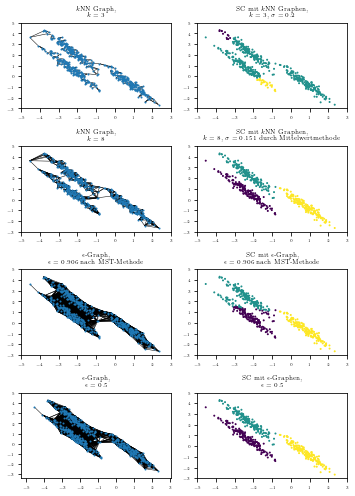

In [29]:
import matplotlib

matplotlib.rcParams.update({
   "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(20,30))



#kNN-Graph mit k = 3
ax[0,0].set_title(' $k$NN Graph, \n $k = 3$', fontsize=6, fontweight='demi')
nx.draw(G_2_knn_3,arrows= True, pos = pos_2, node_size = 1, width= 0.5, ax=ax[0,0] )
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0,0].set_xlim([-5, 3])
ax[0,0].set_ylim([-3, 5])

ax[0,1].set_title('SC mit $k$NN Graphen, \n $k = 3$, $\sigma =0.2 $', fontsize=6, fontweight='demi')
ax[0,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 1, c= Daten_2_knn_3_labels , cmap = 'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0,1].set_xlim([-5, 3])
ax[0,1].set_ylim([-3, 5])

#kNN-Graph mit k = 8
ax[1,0].set_title('$k$NN Graph, \n $k = 8$', fontsize=6, fontweight='demi')
nx.draw(G_2_knn_1, pos = pos_2, node_size = 1, width= 0.5, ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1,0].set_xlim([-5, 3])
ax[1,0].set_ylim([-3, 5])

ax[1,1].set_title('SC mit $k$NN Graphen, \n $k = 8$, $\sigma = 0.151$ durch Mittelwertmethode', fontsize=6, fontweight='demi')
ax[1,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 1, c= Daten_2_knn_1_labels , cmap = 'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1,1].set_xlim([-5, 3])
ax[1,1].set_ylim([-3, 5])





#eps-Graph mit eps = 0.906 durch MST-Methode
ax[2,0].set_title('$\epsilon$-Graph, \n $\epsilon = 0.906 $ nach MST-Methode', fontsize=6, fontweight='demi')
nx.draw(G_2_eps_1, pos = pos_2, node_size = 1, width= 0.5, ax=ax[2,0] )
ax[2,0].set_axis_on()
ax[2,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[2,0].set_xlim([-5, 3])
ax[2,0].set_ylim([-3, 5])

ax[2,1].set_title('SC mit $\epsilon$-Graph, \n $\epsilon = 0.906 $ nach MST-Methode', fontsize=6, fontweight='demi')
ax[2,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 1, c= Daten_2_eps_1_labels, cmap = 'viridis')
ax[2,1].set_axis_on()
ax[2,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[2,1].set_xlim([-5, 3])
ax[2,1].set_ylim([-3, 5])


#eps-Graph mit eps aus MST-Methode
ax[3,0].set_title('$\epsilon$-Graph, \n $\epsilon = 0.5$ ', fontsize=6, fontweight='demi')
nx.draw(G_2_eps_2, pos = pos_2, node_size = 1, width= 0.5, ax=ax[3,0] )
ax[3,0].set_axis_on()
ax[3,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,  labelsize = 4)
ax[0,0].set_xlim([-5, 3])
ax[0,0].set_ylim([-3, 5])

ax[3,1].set_title('SC mit $\epsilon$-Graphen, \n $\epsilon = 0.5$', fontsize=6, fontweight='demi')
ax[3,1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 1, c= Daten_2_eps_2_labels, cmap = 'viridis')
ax[3,1].set_axis_on()
ax[3,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[3,1].set_xlim([-5, 3])
ax[3,1].set_ylim([-3, 5])


fig.tight_layout()

fig.set_size_inches(5.04, 7)
fig.tight_layout()

plt.savefig('Daten_2_knn_eps.pdf')

plt.show()

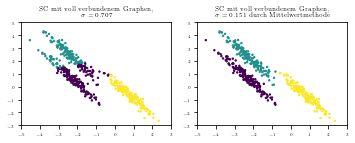

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
ax[0].set_title('SC mit voll verbundenem Graphen, \n $\sigma = 0.707$', fontsize=6, fontweight='demi')
ax[0].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 2, c= Daten_2_voll_1_labels, cmap = 'viridis'  )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0].set_xlim([-5, 3])
ax[0].set_ylim([-3, 5])


ax[1].set_title('SC mit voll verbundenem Graphen,\n $\sigma =  0.151$ durch Mittelwertmethode', fontsize=6, fontweight='demi')
ax[1].scatter(Daten_2[:, 0], Daten_2[:, 1], s= 2, c= Daten_2_voll_2_labels, cmap = 'viridis'  )
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1].set_xlim([-5, 3])
ax[1].set_ylim([-3, 5])


fig.tight_layout()

fig.set_size_inches(5.04, 2.1)
fig.tight_layout()

plt.savefig('Daten_2_voll_verb.pgf')
plt.show()